import pandas as pd
import os
# Defina o diretório onde seus arquivos CSV estão localizados
diretorio_csv = 'C:/Users/miche/Desktop/CAPSTONE/insper0924'

# Lista todos os arquivos na pasta
arquivos_csv = [arquivo for arquivo in os.listdir(diretorio_csv) if arquivo.lower().endswith('.csv')]


#load data bases
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [25]:
!pip install prophet

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import prophet
from yahoofinancials import YahooFinancials
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from darts.models import (
    NaiveSeasonal,
    NaiveDrift,
    Prophet,
    ExponentialSmoothing,
    ARIMA,
    AutoARIMA,
    TBATS,
    StatsForecastAutoARIMA
)
from darts import TimeSeries
import pmdarima as pmd


### Carregar o banco de dados ajustado com os spreads

##Remover TaxaCompra e TaxaVenda = 0

In [12]:
#load db preco_anbima and then return the unique values of the column 'correcao'
preco_anbima = pd.read_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/preco_anbima_ajustado.csv')
#contagem de registros
print(preco_anbima.count())

Unnamed: 0             380979
id                     380979
dataReferencia         380979
codigo                 380979
nome                   380979
repacVenc              380979
indice                 380979
correcao               380979
taxaCompra             380979
taxaVenda              380979
taxaIndicativa         380979
desvioPadrao           380979
intervaloMin           380979
intervaloMax           380979
pu                     380979
percPu                 380979
duration               380979
percReune              380979
referenciaNTNB         380979
spread_bid_ask         380979
spread                 380979
spread_2               380979
taxaIndicativa_diff    380294
dtype: int64


In [5]:
#guardar o novo dataframe em um arquivo csv
#preco_anbima.to_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/preco_anbima_ajustado.csv', index=False)

### Cria banco de dados para o codigo ALGA28 com nome preco_anbima_ALGA28

In [13]:
#criar um banco de dados apenas filtrando apenas pelo codigo alga28
preco_anbima_ALGA28 = preco_anbima[preco_anbima['codigo'] == 'ALGA28']
print(preco_anbima_ALGA28)
preco_anbima_ALGA28.to_csv('C:/Users/miche/Desktop/CAPSTONE/Capstone/preco_anbima_ALGA28.csv', index=False)

       Unnamed: 0       id dataReferencia  codigo               nome  \
14859      143382   215452     2019-07-15  ALGA28  ALGAR TELECOM S/A   
14860      143715   215785     2019-07-16  ALGA28  ALGAR TELECOM S/A   
14861      144048   216118     2019-07-17  ALGA28  ALGAR TELECOM S/A   
14862      144381   216451     2019-07-18  ALGA28  ALGAR TELECOM S/A   
14863      144714   216784     2019-07-19  ALGA28  ALGAR TELECOM S/A   
...           ...      ...            ...     ...                ...   
16146      991521  1946395     2024-09-26  ALGA28  ALGAR TELECOM S/A   
16147      992515  1947389     2024-09-27  ALGA28  ALGAR TELECOM S/A   
16148      993516  1948390     2024-09-30  ALGA28  ALGAR TELECOM S/A   
16149      994513  1949387     2024-10-01  ALGA28  ALGAR TELECOM S/A   
16150      995512  1950386     2024-10-02  ALGA28  ALGAR TELECOM S/A   

        repacVenc  indice   correcao  taxaCompra  taxaVenda  ...  \
14859  2026-02-15     0.9  di_spread      0.8920     0.7600  ...   

### Para exemplificar vamos utilizar o codigo ALGA28 num periodo de 1 ano

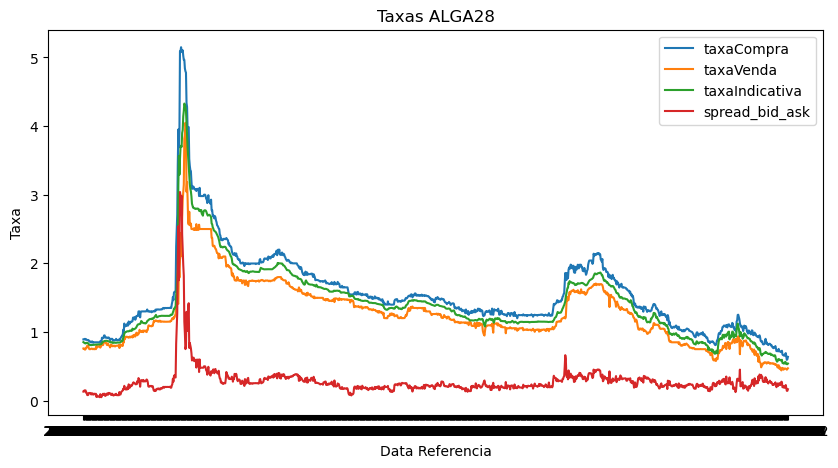

In [14]:
#criar um grafico de linha com o dataframe preco_anbima_ALGA28 usando dataReferencia no eixo x e taxaCompra, taxaVenda, taxaIndicativa, Spread_bid_ask no eixo y, filtrar apenas os dados de dataReferencia entre 2020 e 2022

preco_anbima_ALGA28_2020 = preco_anbima_ALGA28[(preco_anbima_ALGA28['dataReferencia'] >= '2020-01-01') & (preco_anbima_ALGA28['dataReferencia'] <= '2020-12-31')]
plt.figure(figsize=(10,5))
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaCompra'], label='taxaCompra')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaVenda'], label='taxaVenda')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['taxaIndicativa'], label='taxaIndicativa')
plt.plot(preco_anbima_ALGA28['dataReferencia'], preco_anbima_ALGA28['spread_bid_ask'], label='spread_bid_ask')
plt.xlabel('Data Referencia')
plt.ylabel('Taxa')
plt.title('Taxas ALGA28')
plt.legend()
plt.show()

### Rodar uma analise de correlacao entre as variaveis dentro do titulo ALGA28

#### Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

+ Remover a tendencia
+ Remover a sazonalidade
+ Remover a autocorrelacao
+ colocarr a base logaritmica (Se tiver uma tendencia exponencial)
+ Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
+ Dado essa serie aplique Dick Fuller, e trace a media da curva.
+ Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#### Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
# aplicar a regressao classica na serie mais estacionaria.

# INICIO DA ANALISE

## Utilizando apenas o dataset com o codigo ALGA28
- Valores Nulos foram descartados
- Foco na Variável taxaIndicativa e dataReferencia

In [15]:
#vverificar o tipo de variavel de cada um dos campos do dataframe preco_anbima_ALGA28
print(preco_anbima_ALGA28.dtypes)

Unnamed: 0               int64
id                       int64
dataReferencia          object
codigo                  object
nome                    object
repacVenc               object
indice                 float64
correcao                object
taxaCompra             float64
taxaVenda              float64
taxaIndicativa         float64
desvioPadrao            object
intervaloMin            object
intervaloMax            object
pu                      object
percPu                  object
duration                object
percReune                int64
referenciaNTNB          object
spread_bid_ask         float64
spread                 float64
spread_2               float64
taxaIndicativa_diff    float64
dtype: object


### ALTERAÇÕES

- Mudar o alias do dataset
- Converter variavel dataReferencia para datetime
- Ordenar os dados pela data

In [16]:
#mudar o nome do dataset para df
df = preco_anbima_ALGA28
from statsmodels.tsa.seasonal import seasonal_decompose

# Converter dataReferencia para datetime
df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')

# Ordenar os dados pela data
df = df.sort_values(by='dataReferencia')



C:\Users\miche\AppData\Local\Temp\ipykernel_2512\3261870845.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['dataReferencia'] = pd.to_datetime(df['dataReferencia'], errors='coerce')


# Decomposição de série temporal

## 1 - Remoção da tendência

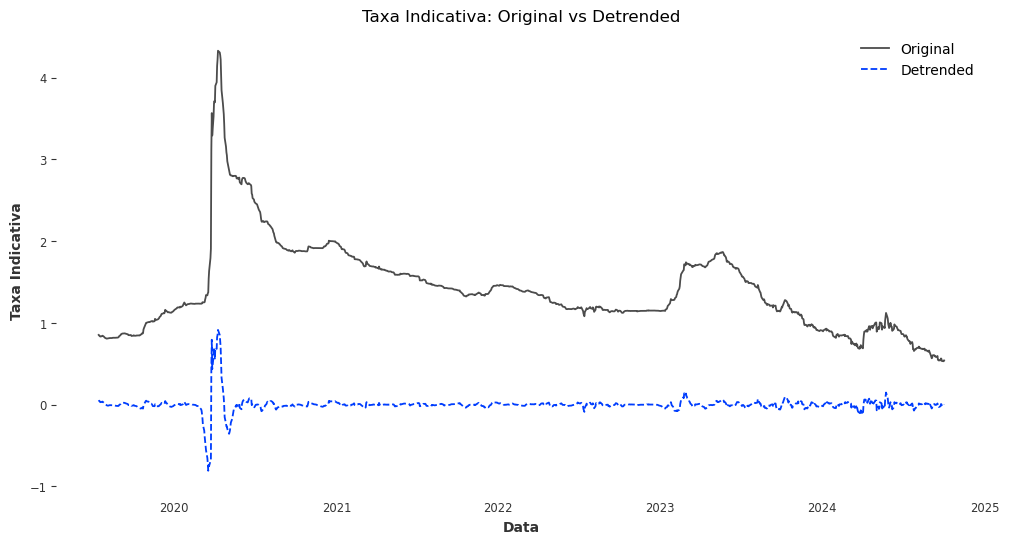

In [34]:
# Decomposição de série temporal e remoção da tendência
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')
df['taxaIndicativa_detrended'] = df['taxaIndicativa'] - result.trend

# Plotar a série temporal original e a série temporal sem a tendência
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_detrended'], label='Detrended', linestyle='--')
plt.title('Taxa Indicativa: Original vs Detrended')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()

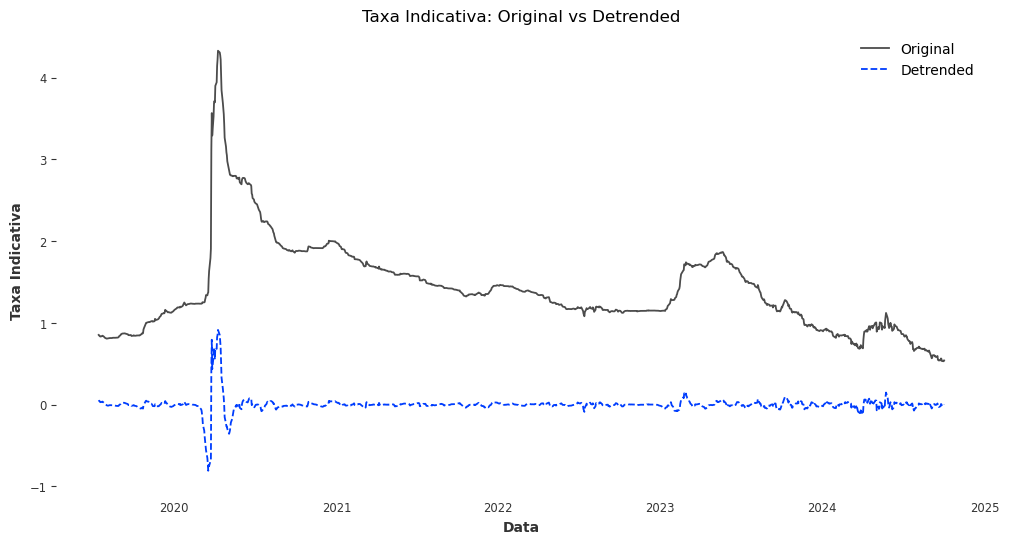

## 2- Remover a sazonalidade 
### O modelo de remoção multiplicativa performou melhor que o aditivo

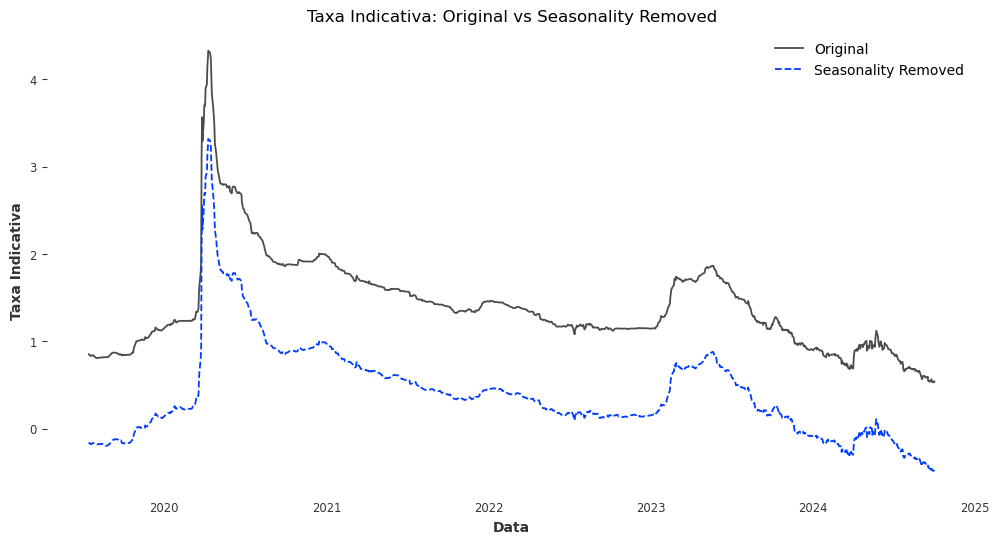

In [31]:
# Decomposição completa para a série original "taxaIndicativa"
result_full = seasonal_decompose(df['taxaIndicativa'], model='multiplicative', period=30, extrapolate_trend='freq')

# Remover apenas a sazonalidade sem remover a tendência
df['taxaIndicativa_no_season'] = df['taxaIndicativa'] - result_full.seasonal

# Plotar os resultados
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_season'], label='Seasonality Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Seasonality Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


## 3- Remover a autocorrelação utilizando o ARIMA

c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\miche\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


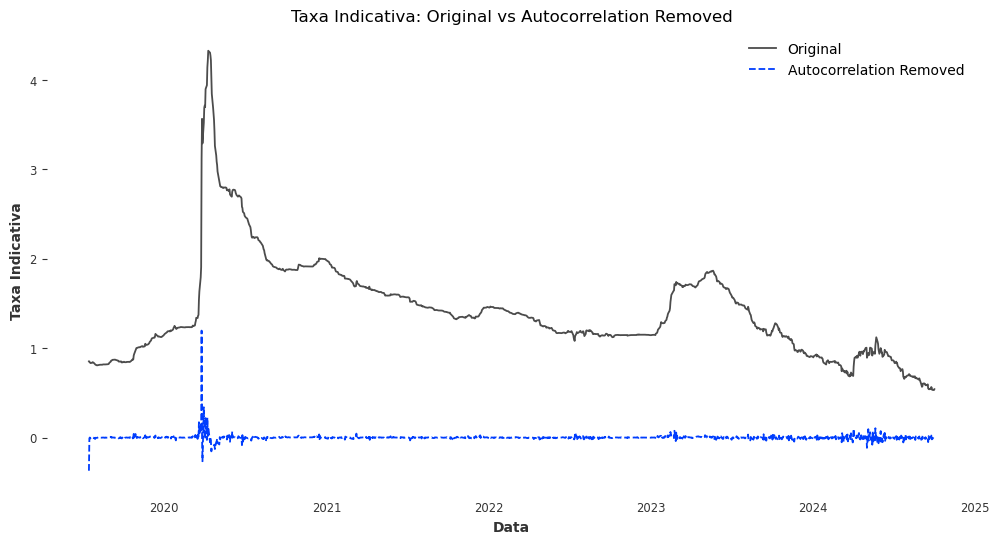

In [32]:
from statsmodels.tsa.arima.model import ARIMA

# Ajustar um modelo ARIMA para capturar autocorrelação
model = ARIMA(df['taxaIndicativa'].dropna(), order=(1, 0, 1))  # Modelo ARMA(1,1)
model_fit = model.fit()

# Obter os resíduos (valores sem autocorrelação)
df['taxaIndicativa_no_autocorr'] = model_fit.resid

# Plotar a série original e os resíduos sem autocorrelação
plt.figure(figsize=(12, 6))
plt.plot(df['dataReferencia'], df['taxaIndicativa'], label='Original', alpha=0.7)
plt.plot(df['dataReferencia'], df['taxaIndicativa_no_autocorr'], label='Autocorrelation Removed', linestyle='--')
plt.title('Taxa Indicativa: Original vs Autocorrelation Removed')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.legend()
plt.grid()
plt.show()


## 4 - Realizar o teste ADF para saber o tipo de estacionaridade da série temporal

In [35]:
#realizar o teste adf para verificar se a serie é estacionaria
result = adfuller(df['taxaIndicativa'])
print('ADF Statistic: %f' % result[0])

ADF Statistic: -2.018900


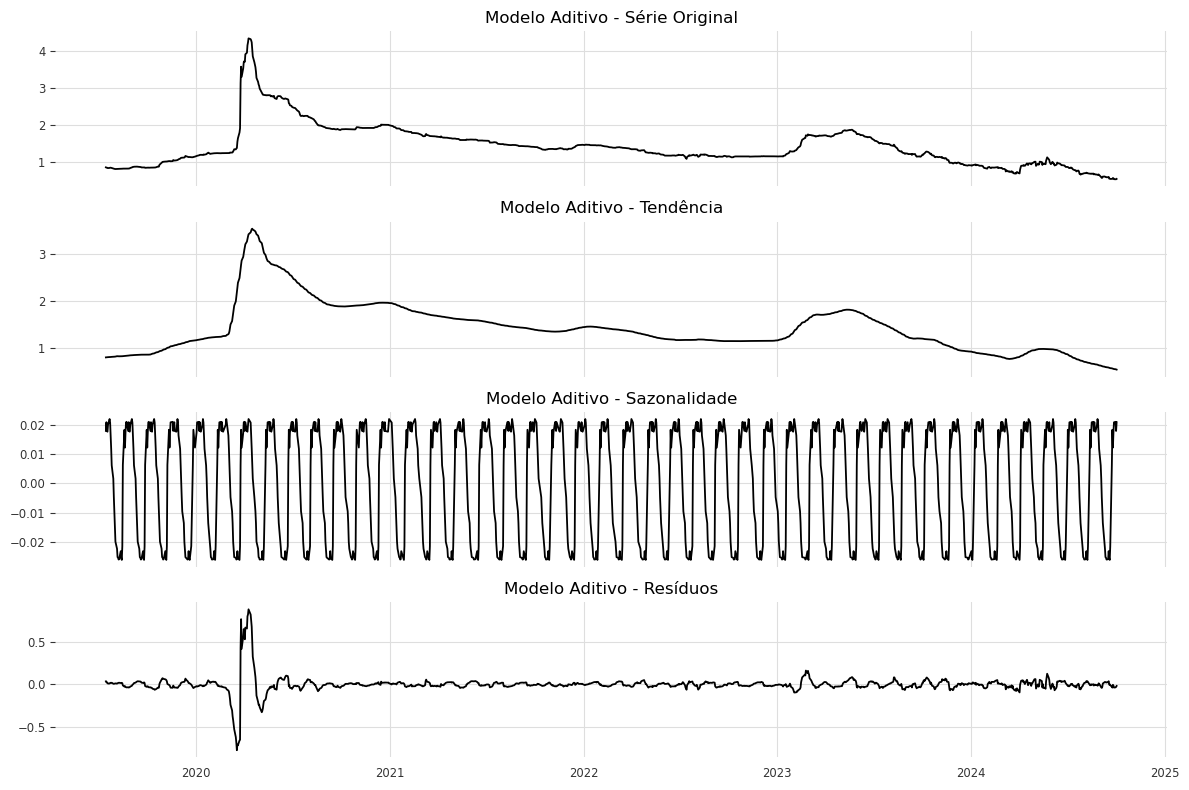

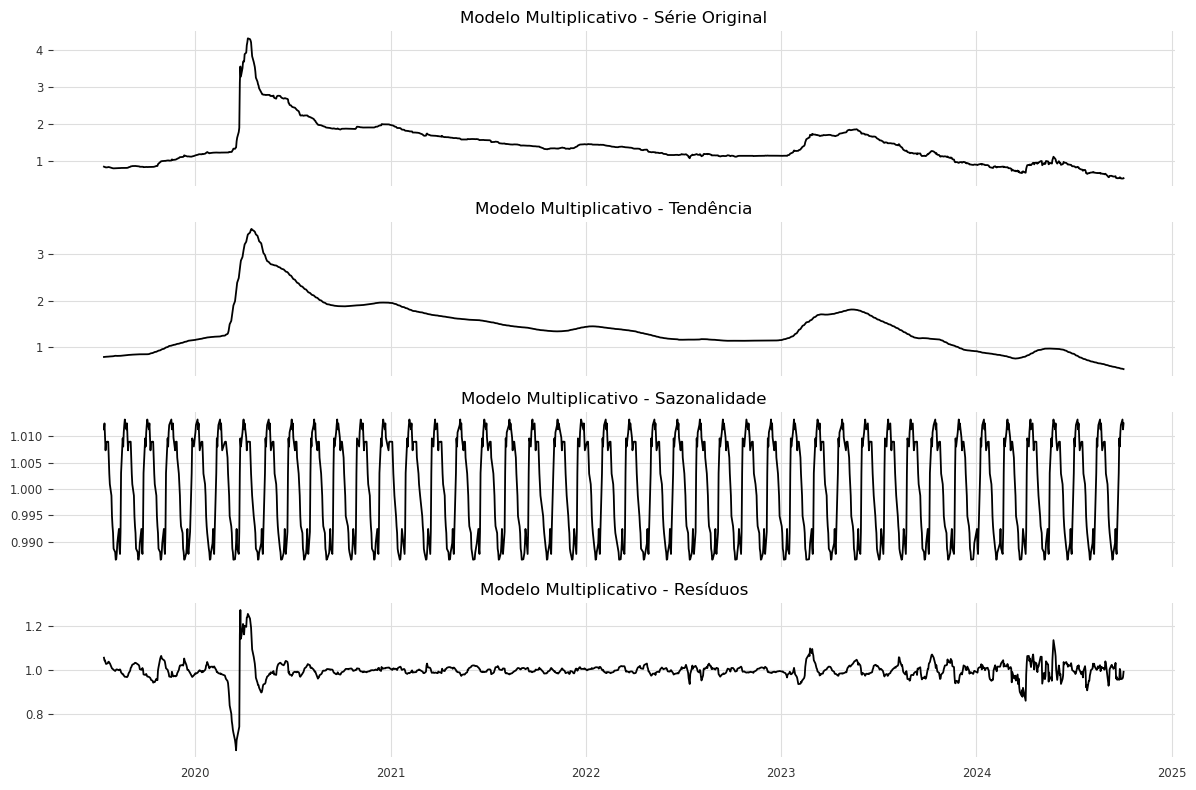

In [37]:
# Decomposição aditiva
result_add = seasonal_decompose(df['taxaIndicativa'], model='additive', period=30, extrapolate_trend='freq')

# Decomposição multiplicativa
result_mult = seasonal_decompose(df['taxaIndicativa'], model='multiplicative', period=30, extrapolate_trend='freq')

# Plotar os componentes para o modelo aditivo
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df['dataReferencia'], df['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Aditivo - Série Original')
axes[1].plot(df['dataReferencia'], result_add.trend, label='Tendência')
axes[1].set_title('Modelo Aditivo - Tendência')
axes[2].plot(df['dataReferencia'], result_add.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Aditivo - Sazonalidade')
axes[3].plot(df['dataReferencia'], result_add.resid, label='Resíduos')
axes[3].set_title('Modelo Aditivo - Resíduos')
plt.tight_layout()
plt.show()

# Plotar os componentes para o modelo multiplicativo
fig, axes = plt.subplots(4, 1, figsize=(12, 8), sharex=True)
axes[0].plot(df['dataReferencia'], df['taxaIndicativa'], label='Original')
axes[0].set_title('Modelo Multiplicativo - Série Original')
axes[1].plot(df['dataReferencia'], result_mult.trend, label='Tendência')
axes[1].set_title('Modelo Multiplicativo - Tendência')
axes[2].plot(df['dataReferencia'], result_mult.seasonal, label='Sazonalidade')
axes[2].set_title('Modelo Multiplicativo - Sazonalidade')
axes[3].plot(df['dataReferencia'], result_mult.resid, label='Resíduos')
axes[3].set_title('Modelo Multiplicativo - Resíduos')
plt.tight_layout()
plt.show()


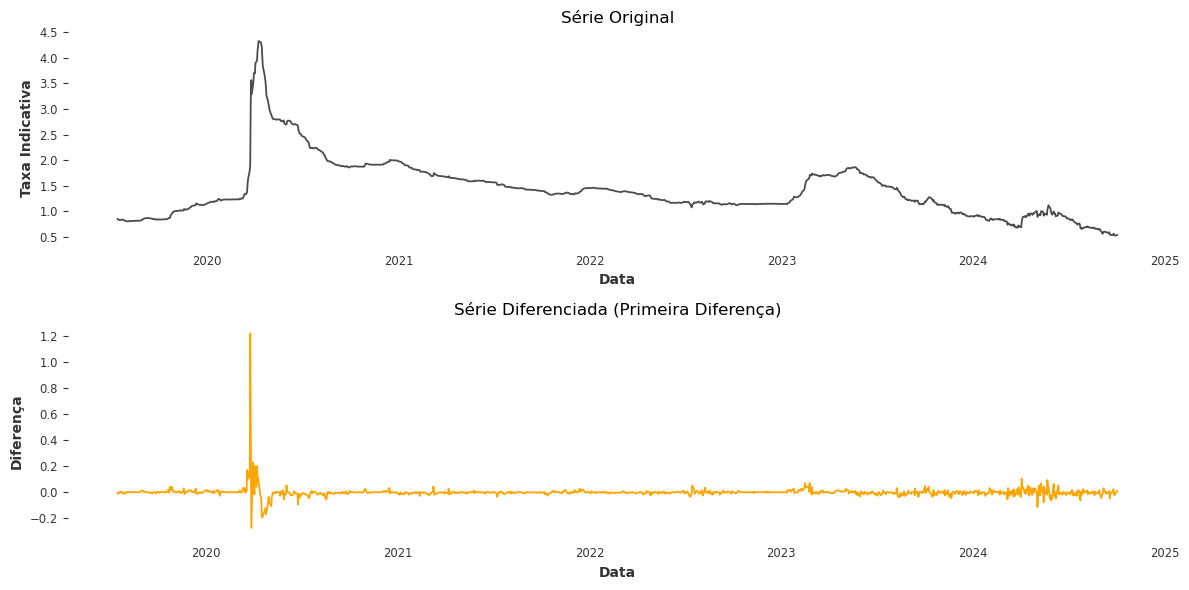

NameError: name 'adf_statistic_diff' is not defined

In [39]:
# Ajustar o Df para o data_valid
df_valid = df

# Ajustar o desalinhamento de índices após a diferenciação
df_valid_diff = df_valid.dropna(subset=['taxaIndicativa_diff'])

# Plotar novamente com correção
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(df_valid['dataReferencia'], df_valid['taxaIndicativa'], label='Série Original', alpha=0.7)
plt.title('Série Original')
plt.xlabel('Data')
plt.ylabel('Taxa Indicativa')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(df_valid_diff['dataReferencia'], df_valid_diff['taxaIndicativa_diff'], label='Série Diferenciada', color='orange')
plt.title('Série Diferenciada (Primeira Diferença)')
plt.xlabel('Data')
plt.ylabel('Diferença')
plt.grid()

plt.tight_layout()
plt.show()

# Reapresentar os resultados do teste ADF
adf_statistic_diff, p_value_diff, critical_values_diff, "A série é estacionária." if p_value_diff < 0.05 else "A série não é estacionária."


In [ ]:
#Aplicar todas as diferenciaoes possiveis (ao menos 3) e verificar qual apresenta uma estacionaridade melhor

#Remover a tendencia
#Remover a sazonalidade
#Remover a autocorrelacao
#colocarr a base logaritmica (Se tiver uma tendencia exponencial)
#Aplicar a transformacao de raiz quadrada (Se tiver uma tendencia quadratica)
#Dado essa serie aplique Dick Fuller, e trace a media da curva.
#Fica de olho no resultado do P valor do teste em relacao a cada um dos modelos acima.

#Passo 2 => Olhar visualmente e pelo teste cada uma das series e na sequencia aplicar o modelo preditivo quais(todos ensinados pela Paloma), 
# aplicar a regressao classica na serie mais estacionaria.

In [ ]:
#remover a tendencia da variavel temporal taxaIndicativa


NameError: name 'series' is not defined